In [1]:
from datetime import datetime
from meteostat import Hourly, Point
import pandas as pd

In [2]:
pjm_df = pd.read_csv("PJM_Load_hourly.csv")

In [3]:
pjm_df.head()

,Datetime,PJM_Load_MW
0,1998-12-31 01:00:00,29309.0
1,1998-12-31 02:00:00,28236.0
2,1998-12-31 03:00:00,27692.0
3,1998-12-31 04:00:00,27596.0
4,1998-12-31 05:00:00,27888.0


In [4]:
# Prepare datetime format
pjm_df["Datetime"] = pd.to_datetime(pjm_df["Datetime"])
start = pjm_df["Datetime"].min()
end = pjm_df["Datetime"].max()

In [5]:
location = Point(39.9526, -75.1652)

In [6]:
# Fetch weather data
weather = Hourly(location, start, end)
weather = weather.fetch()
weather_df = weather[["temp", "rhum"]].reset_index()
weather_df.columns = ["Datetime", "Temperature_C", "Humidity_%"]

In [7]:
# Merge with PJM data
merged_df = pd.merge(pjm_df, weather_df, on="Datetime", how="inner")

In [8]:
merged_df.head()

,Datetime,PJM_Load_MW,Temperature_C,Humidity_%
0,1998-12-31 01:00:00,29309.0,-5.0,42.0
1,1998-12-31 02:00:00,28236.0,-5.6,40.0
2,1998-12-31 03:00:00,27692.0,-6.1,41.0
3,1998-12-31 04:00:00,27596.0,-6.7,43.0
4,1998-12-31 05:00:00,27888.0,-6.7,49.0


In [9]:

merged_df.to_csv("pjm_with_weather.csv", index=False)

In [10]:

# Parse datetime and sort
merged_df["Datetime"] = pd.to_datetime(merged_df["Datetime"])
merged_df = merged_df.sort_values("Datetime").reset_index(drop=True)

In [12]:
merged_df.head()

,Datetime,PJM_Load_MW,Temperature_C,Humidity_%
0,1998-04-01 01:00:00,22259.0,22.2,66.0
1,1998-04-01 02:00:00,21244.0,21.1,71.0
2,1998-04-01 03:00:00,20651.0,18.9,81.0
3,1998-04-01 04:00:00,20421.0,18.9,81.0
4,1998-04-01 05:00:00,20713.0,18.3,84.0


In [13]:
features = ["PJM_Load_MW", "Temperature_C", "Humidity_%"]

In [28]:
data=merged_df[features].copy()

In [29]:
data = data.dropna()

In [30]:
data = data.astype(float)

In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)


In [33]:

scaled_data = pd.DataFrame(scaled, columns=data.columns, index=data.index)

In [34]:
def create_sequences(data, lookback=24, predict_ahead=1):
    X, y = [], []
    for i in range(lookback, len(data) - predict_ahead):
        X.append(data[i - lookback:i])
        y.append(data[i + predict_ahead - 1][0])  # Predicting PJM_Load_MW
    return np.array(X), np.array(y)

In [35]:
lookback = 24   # Use past 24 hours
X, y = create_sequences(scaled, lookback=lookback)


In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [38]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=opt, loss='mse')

In [41]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/20
740/740 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0167 - val_loss: 0.0041
Epoch 2/20
740/740 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0041 - val_loss: 0.0018
Epoch 3/20
740/740 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0023 - val_loss: 9.9007e-04
Epoch 4/20
740/740 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0016 - val_loss: 6.3975e-04
Epoch 5/20
740/740 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0012 - val_loss: 5.7380e-04
Epoch 6/20
740/740 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 9.2544e-04 - val_loss: 3.6831e-04
Epoch 7/20
740/740 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 7.9854e-04 - val_loss: 3.3369e-04
Epoch 8/20
740/740 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 7.3783e-04 - val_loss: 3.6198e-04
Epoch 9/20
740/740 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 6.7712e-04 - val_loss: 4.6985e-04
Epoch 10/20
740/740 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 6.9356e-04 - val_loss: 3.8663e-04
Epoch 11/20
740/740 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 6.8064e-04 - v

In [42]:
predictions = model.predict(X_test)

206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [43]:
pad = np.zeros((predictions.shape[0], scaled.shape[1]))
pad[:, 0] = predictions[:, 0]  # Set only PJM_Load_MW column

In [44]:
predicted_load = scaler.inverse_transform(pad)[:, 0]
actual_load = scaler.inverse_transform(
    np.pad(y_test.reshape(-1, 1), ((0,0), (0,2)), 'constant')
)[:, 0]

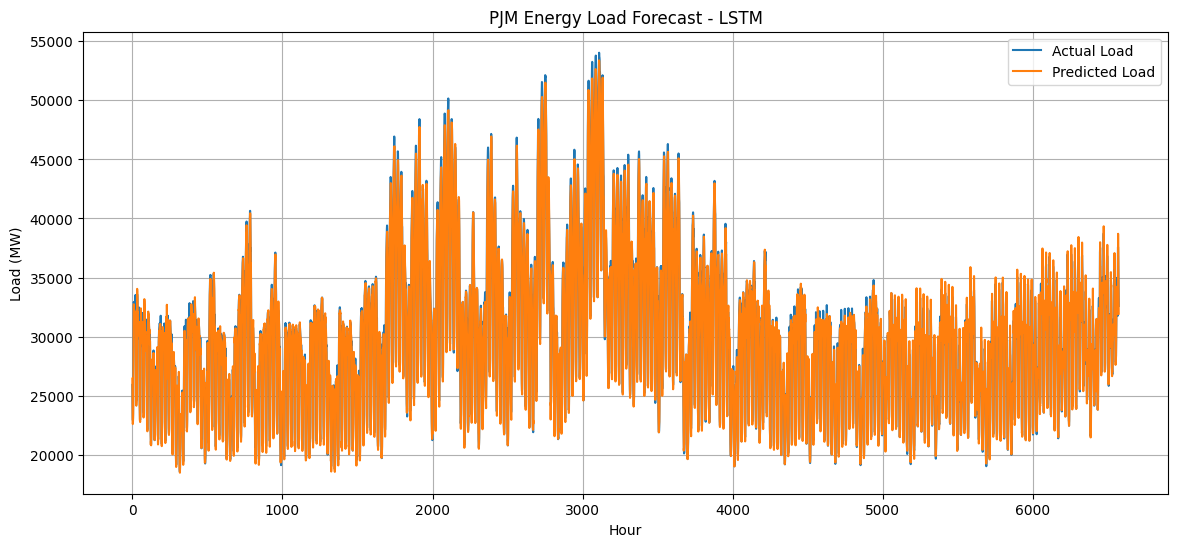

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
plt.plot(actual_load, label='Actual Load')
plt.plot(predicted_load, label='Predicted Load')
plt.title("PJM Energy Load Forecast - LSTM")
plt.xlabel("Hour")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate accuracy metrics
mae = mean_absolute_error(actual_load, predicted_load)
mse = mean_squared_error(actual_load, predicted_load)
rmse = np.sqrt(mse)
r2 = r2_score(actual_load, predicted_load)

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((actual_load - predicted_load) / actual_load)) * 100

print("=== Model Accuracy Metrics ===")
print(f"Mean Absolute Error (MAE): {mae:.2f} MW")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} MW")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy (100 - MAPE): {100 - mape:.2f}%")

=== Model Accuracy Metrics ===
Mean Absolute Error (MAE): 410.49 MW
Mean Squared Error (MSE): 326504.26
Root Mean Squared Error (RMSE): 571.41 MW
R² Score: 0.9920
Mean Absolute Percentage Error (MAPE): 1.36%
Accuracy (100 - MAPE): 98.64%


In [48]:
# Save the trained model
model.save('pjm_lstm_model.keras')  # Using the recommended .keras format
print("Model saved as 'pjm_lstm_model.keras'")

# Also save the scaler for future use
import joblib
joblib.dump(scaler, 'pjm_scaler.pkl')
print("Scaler saved as 'pjm_scaler.pkl'")

# Save model summary to text file with proper encoding
with open('model_summary.txt', 'w', encoding='utf-8') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
print("Model summary saved as 'model_summary.txt'")

Model saved as 'pjm_lstm_model.keras'
Scaler saved as 'pjm_scaler.pkl'


Model summary saved as 'model_summary.txt'


In [49]:
# Load the model
from tensorflow.keras.models import load_model
model = load_model('pjm_lstm_model.keras')

# Load the scaler
import joblib
scaler = joblib.load('pjm_scaler.pkl')

In [50]:
# Pad predicted values to match scaler input shape
pad = np.zeros((predictions.shape[0], scaled.shape[1]))
pad[:, 0] = predictions[:, 0]  # Set only PJM_Load_MW column


In [51]:
# Inverse transform only the first column (PJM_Load_MW)
predicted_load = scaler.inverse_transform(pad)[:, 0]

In [52]:
# Now for actual values (y_test):
actual_load = scaler.inverse_transform(
    np.pad(y_test.reshape(-1, 1), ((0,0), (0,2)), 'constant')
)[:, 0]

In [53]:
# === Step 10: Spike Detection ===

# Calculate % change in actual load
load_diff = np.diff(actual_load)
threshold = np.percentile(np.abs(load_diff), 95)  # Top 5% of changes = spikes

spike_indices = np.where(np.abs(load_diff) > threshold)[0] + 1  # +1 to correct for diff shift

print(f"Detected {len(spike_indices)} spikes.")

Detected 329 spikes.


In [55]:
# Get timestamps from test set
test_start_index = len(merged_df) - len(X_test)
spike_times = merged_df.index[test_start_index + spike_indices]

In [57]:
# Fetch weather info at spike times
weather_during_spikes = merged_df.loc[spike_times][['Temperature_C', 'Humidity_%']]
load_at_spikes = merged_df.loc[spike_times]['PJM_Load_MW']


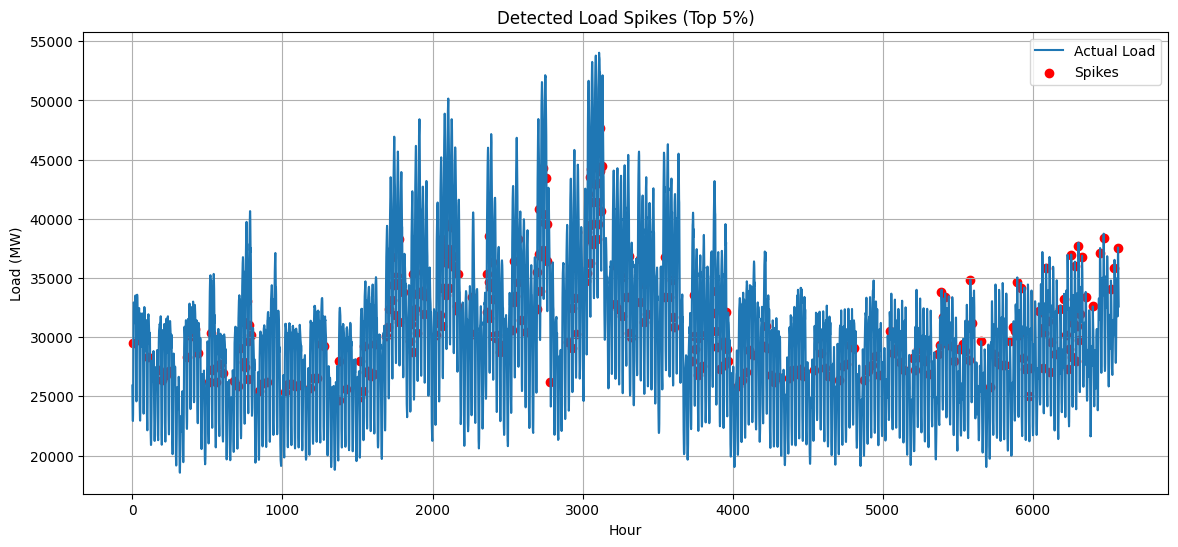

In [58]:
# === Step 12: Plot Results ===

# 1. Load with spike points
plt.figure(figsize=(14,6))
plt.plot(actual_load, label='Actual Load')
plt.scatter(spike_indices, actual_load[spike_indices], color='red', label='Spikes')
plt.title("Detected Load Spikes (Top 5%)")
plt.xlabel("Hour")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()


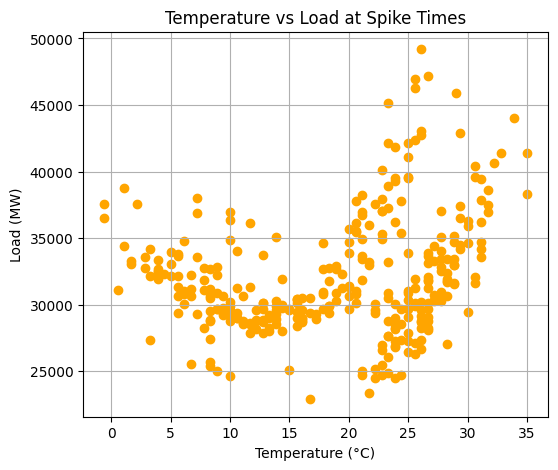

In [59]:
# 2. Scatter plot: Temperature vs Load at spikes
plt.figure(figsize=(6,5))
plt.scatter(weather_during_spikes['Temperature_C'], load_at_spikes, c='orange')
plt.title("Temperature vs Load at Spike Times")
plt.xlabel("Temperature (°C)")
plt.ylabel("Load (MW)")
plt.grid(True)
plt.show()

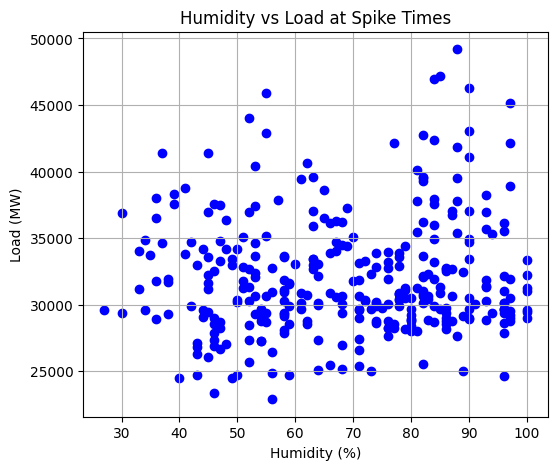

In [60]:
# 3. Scatter plot: Humidity vs Load at spikes
plt.figure(figsize=(6,5))
plt.scatter(weather_during_spikes['Humidity_%'], load_at_spikes, c='blue')
plt.title("Humidity vs Load at Spike Times")
plt.xlabel("Humidity (%)")
plt.ylabel("Load (MW)")
plt.grid(True)
plt.show()

In [61]:
errors = np.abs(actual_load - predicted_load)


In [62]:
error_threshold = np.percentile(errors, 97.5)

In [63]:
anomaly_indices = np.where(errors > error_threshold)[0]
print(f"Detected {len(anomaly_indices)} anomalies.")


Detected 165 anomalies.


In [65]:
test_start_index = len(merged_df) - len(X_test)
anomaly_times = merged_df.index[test_start_index + anomaly_indices]
anomaly_data = merged_df.loc[anomaly_times].copy()
anomaly_data['Error'] = errors[anomaly_indices]
anomaly_data['Actual_Load'] = actual_load[anomaly_indices]
anomaly_data['Predicted_Load'] = predicted_load[anomaly_indices]
anomaly_data['Anomaly'] = True

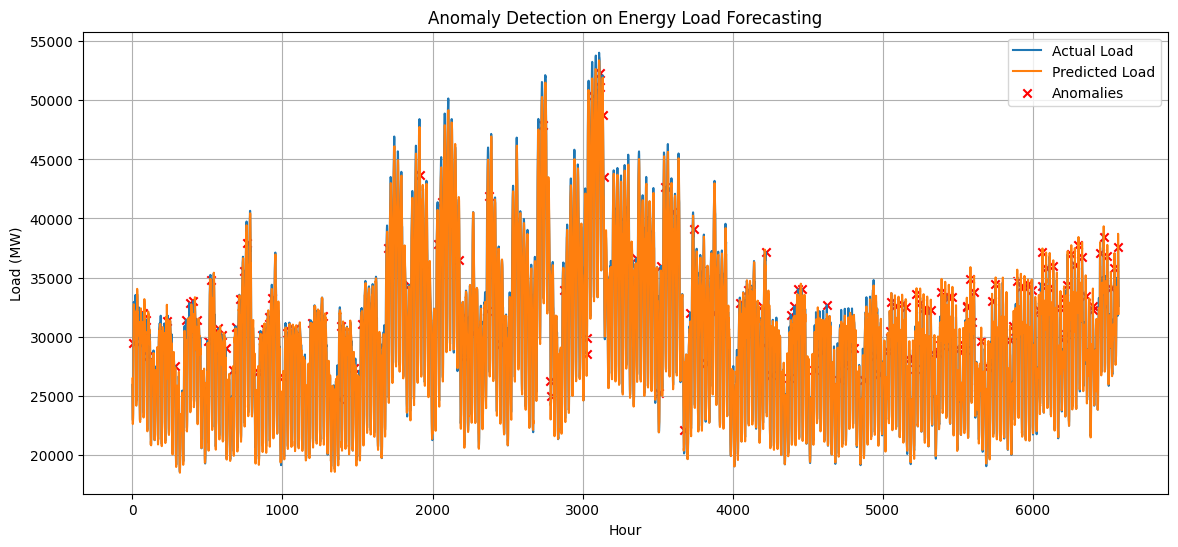

In [66]:
plt.figure(figsize=(14,6))
plt.plot(actual_load, label='Actual Load')
plt.plot(predicted_load, label='Predicted Load')
plt.scatter(anomaly_indices, actual_load[anomaly_indices], color='red', label='Anomalies', marker='x')
plt.title("Anomaly Detection on Energy Load Forecasting")
plt.xlabel("Hour")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()


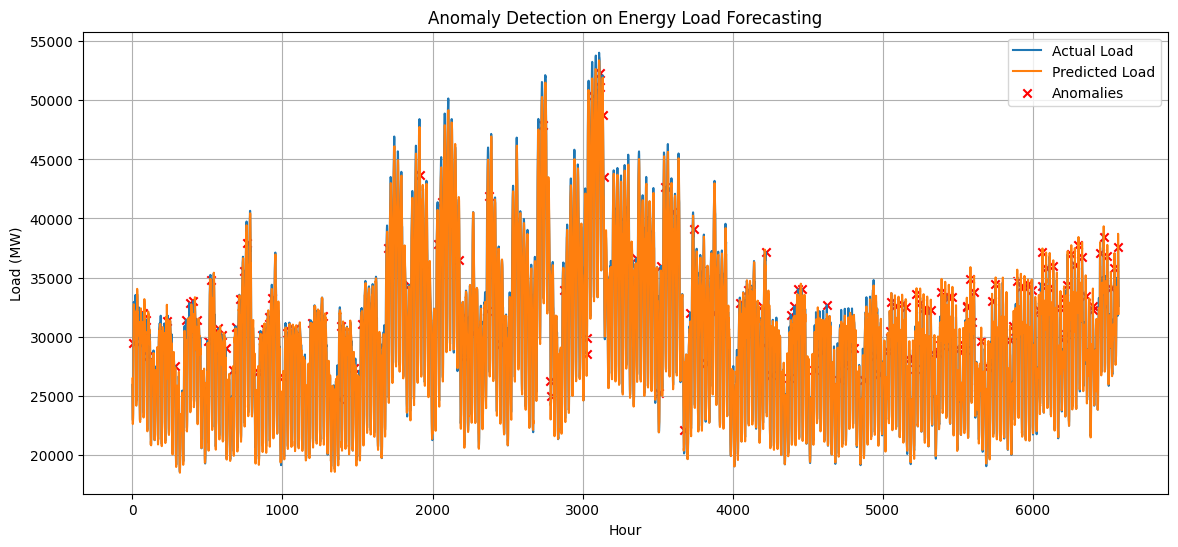

In [67]:
plt.figure(figsize=(14,6))
plt.plot(actual_load, label='Actual Load')
plt.plot(predicted_load, label='Predicted Load')
plt.scatter(anomaly_indices, actual_load[anomaly_indices], color='red', label='Anomalies', marker='x')
plt.title("Anomaly Detection on Energy Load Forecasting")
plt.xlabel("Hour")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()


In [68]:
anomaly_data.reset_index().to_csv("detected_anomalies.csv", index=False)
